In [114]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,Input,Dense, Reshape, ReLU, Permute
from keras.utils.vis_utils import plot_model
import numpy as np

### Load data Functions

In [21]:
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

MAX_LEN = 50  # maximum length of the sequence

def triplets(sequences):
    """
    Apply sliding window of length 3 to each sequence in the input list
    :param sequences: list of sequences
    :return: numpy array of triplets for each sequence
    Usage: Split protein sequence into triplets of aminoacids
    """
    return np.array([[aminoacids[i:i+3] for i in range(len(aminoacids))] for aminoacids in sequences])

def get_data(return_sequence=False):
    """

    :param return_sequence: parameter that specifies whether we want to return raw sequence or its embedding
    :return: X_train,X_test,Y_train,Y_test
    """
    path = '/content/drive/My Drive/Colab Notebooks/FB-GAN_496/data/2018-06-06-ss.cleaned.csv'
    df = pd.read_csv(path)

    """
    Columns of interest for classification:
    seq: the sequence of the peptide
    sst8: the eight-state (Q8) secondary structure
    sst3: the three-state (Q3) secondary structure
    len: the length of the peptide
    has_nonstd_aa: whether the peptide contains nonstandard amino acids (B, O, U, X, or Z).
    """
    input_seqs, target_seqs = df[['seq', 'sst8']][(df.len <= MAX_LEN) & (~df.has_nonstd_aa)].values.T

    # Transform features
    tokenizer_encoder = Tokenizer()
    input_grams = triplets(input_seqs)
    tokenizer_encoder.fit_on_texts(input_grams)
    input_data = tokenizer_encoder.texts_to_sequences(input_grams)
    input_data = sequence.pad_sequences(input_data, maxlen=MAX_LEN, padding='post')

    # Transform targets
    tokenizer_decoder = Tokenizer(char_level=True)
    tokenizer_decoder.fit_on_texts(target_seqs)
    target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
    target_data = sequence.pad_sequences(target_data, maxlen=MAX_LEN, padding='post')
    target_data = to_categorical(target_data)

    X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.3, random_state=1)
    seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.3,random_state=1)
    
    if return_sequence:
        return seq_train,seq_test,target_train,target_test
    else:
        return X_train,X_test,y_train,y_test



In [226]:
import numpy as np
import pandas as pd

MAX_LEN = 50
MIN_LEN = 40

def get_sequences(path = None, min_len = MIN_LEN, max_len = MAX_LEN):
    if path is None:
        path = '/content/drive/My Drive/Colab Notebooks/FB-GAN_496/data/2018-06-06-ss.cleaned.csv'

    df = pd.read_csv(path)
    input_seqs, target_seqs = df[['seq', 'sst8']][(df.len >= min_len) & (df.len <= max_len) & (~df.has_nonstd_aa)].values.T
    seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.3,random_state=1)
    
    return seq_train,seq_test,target_train,target_test

def get_dataset(sequences, batch_size = BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(sequences)
    dataset = dataset.shuffle(sequences.shape[0], seed=0).batch(batch_size)
    return dataset


In [266]:
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences


class OneHot_Seq():
    def __init__(self, amino_acids = None, max_length = MAX_LEN, min_length = MIN_LEN):

        if amino_acids is None:
            self.amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E','G', 'H', 'I', 'L', 'K', 
               'M', 'F', 'P','S', 'T', 'W', 'Y', 'V']
        else: 
            self.amino_acids = amino_acids
        
        self.amino_acids_dict = {f'{aa}': i+1 for i,aa in enumerate(self.amino_acids)}      
        self.invert_dict = {v: k for k, v in self.amino_acids_dict.items()}
        self.invert_dict[0] = '0'

        self.max_length = max_length


    def _parse_pad_sequences(self, sequences):
        '''
        Parse strings into sequences encoded with integers 1-21 for amino acids or 0 if padded
        '''
        parse = lambda seq: np.array([a for a in seq])
        parsed = pd.DataFrame(sequences).iloc[:,0].apply(parse)


        for i in range(parsed.shape[0]):
            parsed[i] = np.vectorize(self.amino_acids_dict.get)(parsed[i])
        
        parsed = pad_sequences(parsed, maxlen = self.max_length, value = 0, padding = 'post')

        return parsed

    def seq_to_onehot(self,sequences):
        '''
        Inputs
        sequences (ndarray)     array of strings with shape (N, 1) where N is the number of samples. For example, [['AEGYCDQHILKFPS'],['CEHYDEAEGYS']] 

        Returns
        onehot (ndarray)        array of onehot encoded sequences of shape (N, sequence_length, aa_code (0-21))
        '''

        sequences = self._parse_pad_sequences(sequences)

        onehot = []

        for seq in sequences:
            onehot_seq = np.zeros((seq.size, len(self.amino_acids) + 1))
            onehot_seq[np.arange(seq.size),seq] = 1

            onehot.append(onehot_seq)
        
        return np.array(onehot)


    def onehot_to_seq(self, sequences):
        sequences = np.argmax(sequences, axis = 2)
        sequences = np.vectorize(OneHot.invert_dict.get)(sequences)
        decoded_sequences = [[''.join([aa for aa in seq])] for seq in sequences]

        return decoded_sequences


### Load Dataset


In [211]:
X_train,X_test,y_train,y_test = get_sequences()

In [263]:
X = X_train 
OneHot = OneHot_Seq()
real_sequences = OneHot.seq_to_onehot(X)

### GAN

In [223]:
SEQ_LENGTH = 50
DIM = 100
KERNEL_SIZE = 5
BATCH_SIZE = None
N_CHAR = 21
NOISE_SHAPE = 128

def softmax(logits):
    shape = tf.shape(logits)
    res = tf.nn.softmax(tf.reshape(logits, [-1,N_CHAR]))
    return tf.reshape(res, shape)

class ResidualBlock(tf.keras.layers.Layer):

    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.relu = ReLU()
        self.conv1d_1 = Conv1D(filters=DIM, kernel_size=KERNEL_SIZE, padding='same', strides=1, activation='relu')
        self.conv1d_2 = Conv1D(filters=DIM, kernel_size=KERNEL_SIZE, padding='same', strides=1)

    def __call__(self,X,alpha = 0.3):
        x = self.relu(X)
        x = self.conv1d_1(x)
        x = self.conv1d_2(x)
        return x + alpha*x

class Generator(tf.keras.Model):

    def __init__(self):
        """
        implementation of Generator
        :param input_size: size of the sequence (input noise)
        """
        super().__init__(name='generator')

        self.model = tf.keras.models.Sequential()
        self.model.add(Input(shape = (NOISE_SHAPE,), batch_size = BATCH_SIZE))
        self.model.add(Dense(units = DIM*SEQ_LENGTH))
        self.model.add(Reshape((SEQ_LENGTH, DIM)))

        self.model.add(ResidualBlock())
        self.model.add(ResidualBlock())
        self.model.add(ResidualBlock())
        self.model.add(ResidualBlock())
        self.model.add(ResidualBlock())

        self.model.add(Conv1D(filters = N_CHAR, kernel_size = 1))

    def __call__(self, inputs):
        x = self.model(inputs)
        x = softmax(x)
        return x

class Discriminator(tf.keras.Model):

    def __init__(self, clip = 1):
        """
        implementation of Discriminator
        :param clip: value to which you clip the gradients (or False)
        """
        super().__init__(name='discriminator')

        self.model = tf.keras.models.Sequential()
        self.model.add(Input(shape = (SEQ_LENGTH,N_CHAR), batch_size = BATCH_SIZE))
        self.model.add(Conv1D(filters = DIM, kernel_size = 1))

        self.model.add(ResidualBlock())
        self.model.add(ResidualBlock())
        self.model.add(ResidualBlock())
        self.model.add(ResidualBlock())
        self.model.add(ResidualBlock())

        self.model.add(Reshape((-1,DIM*SEQ_LENGTH)))
        self.model.add(Dense(units = DIM*SEQ_LENGTH))
        self.model.add(Dense(units = 1))


    def __call__(self,inputs,training = False):
        """
        model's forward pass
        :param X: input of the size [batch_size, seq_length];
        :param training: specifies the behavior of the call;
        :return: Y: probability of each sequences being real of shape [batch_size, 1]
        """
        x = self.model(inputs)
        return x

In [275]:
import tensorflow as tf
import matplotlib.pyplot as plt
#from Models import Generator, Discriminator

BATCH_SIZE = 32
NOISE_SHAPE = 128


class GAN():

    def __init__(self, batch_size = BATCH_SIZE, discriminator_steps = 5):
        self.batch_size = batch_size
        self.G = Generator()
        self.D = Discriminator()
        self.d_steps = discriminator_steps
        
        self.history = {"G_losses": [], "D_losses": [], "gradient_penalty": [], "sequences": []}

    def compile(self, lr = 0.0002, gradient_penalty_weight = 10):
        self.G_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.5, beta_2=0.9)
        self.D_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.5, beta_2=0.9)

        self.gp_weight = gradient_penalty_weight

    def generate_samples(self, number = None):
        if number is None:
            number = self.batch_size
        z = tf.random.normal([number, NOISE_SHAPE])
        generated = self.G(z)
        return generated

    def generator_loss(self, fake_score):
        return -tf.math.reduce_mean(fake_score)

    def discriminator_loss(self, real_score, fake_score):
        return tf.math.reduce_mean(real_score) - tf.math.reduce_mean(fake_score)

    #@tf.function
    def gradient_penalty(self, real_samples, fake_samples):
        alpha = tf.random.normal([self.batch_size, 1, 1], 0.0, 1.0)
        real_samples = tf.cast(real_samples, tf.float32)
        diff = fake_samples - real_samples
        interpolated = real_samples + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.D(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        
        return gp

    #@tf.function
    def G_train_step(self):
        with tf.GradientTape() as tape:
            fake_samples = self.generate_samples()
            fake_score = self.D(fake_samples, training=True)
            G_loss = self.generator_loss(fake_score)

        G_gradients = tape.gradient(G_loss, self.G.trainable_variables)
        self.G_optimizer.apply_gradients((zip(G_gradients, self.G.trainable_variables)))

        return G_loss

    #@tf.function
    def D_train_step(self, real_samples):
        with tf.GradientTape() as tape:
            fake_samples = self.generate_samples()
            real_score = self.D(real_samples, training=True)
            fake_score = self.D(fake_samples, training=True)

            D_loss = self.discriminator_loss(real_score, fake_score)
            GP = self.gradient_penalty(real_samples, fake_samples) * self.gp_weight
            D_loss = D_loss + GP

        D_gradients = tape.gradient(D_loss, self.D.trainable_variables)
        self.D_optimizer.apply_gradients((zip(D_gradients, self.D.trainable_variables)))

        return D_loss, GP

    def create_dataset(self, inputs):
        dataset = tf.data.Dataset.from_tensor_slices(inputs)
        dataset = dataset.shuffle(inputs.shape[0], seed=0).batch(self.batch_size, drop_remainder = True)
        return dataset

    def train(self, inputs, epochs):
        
        # Pre-train discriminator 
        for step in range(self.d_steps):
            dataset = self.create_dataset(inputs).as_numpy_iterator()
            
            for sample_batch in dataset:
                self.D_train_step(sample_batch)

        # Train discriminator and generator
        for epoch in range(epochs):
            dataset = self.create_dataset(inputs).as_numpy_iterator()

            print(f"Epoch {epoch}/{epochs}:")

            for sample_batch in dataset:
                G_loss = self.G_train_step()
                D_loss, GP = self.D_train_step(sample_batch)
            
            example_sequence = gan.generate_samples(number = 1)
        
            self.history["G_losses"].append(G_loss.numpy())
            self.history["D_losses"].append(D_loss.numpy())
            self.history['gradient_penalty'].append(GP.numpy())
            self.history['sequences'].append(example_sequence)
            
            print(f"\tGenerator loss: {round(G_loss.numpy(),2)}. \tDiscriminator loss: {round(D_loss.numpy(),2)}")


    def plot_history(self):
        D_losses = np.array(self.history['D_losses'])
        G_losses = np.array(self.history['G_losses'])

        plt.plot(np.arange(D_losses.shape[0]), D_losses, label='Discriminator loss')
        plt.plot(np.arange(G_losses.shape[0]), G_losses, label='Generator loss')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend()

        plt.show()

    def show_sequences_history(self):
        OneHot = OneHot_Seq()
        sequences_history = self.history['sequences']
        decod = [OneHot.onehot_to_seq(seq.numpy()) for seq in sequences_history]

        print('History of generated sequences... \n')
        for i in range(len(decod)):
            print(f'Epoch {i}: \t {decod[i][0]}')

Epoch 0/200:
	Generator loss: -5.829999923706055. 	Discriminator loss: -8.359999656677246
Epoch 1/200:
	Generator loss: -11.260000228881836. 	Discriminator loss: -9.380000114440918
Epoch 2/200:
	Generator loss: -11.979999542236328. 	Discriminator loss: -9.869999885559082
Epoch 3/200:
	Generator loss: -9.15999984741211. 	Discriminator loss: -9.199999809265137
Epoch 4/200:
	Generator loss: -11.520000457763672. 	Discriminator loss: -9.359999656677246
Epoch 5/200:
	Generator loss: -9.600000381469727. 	Discriminator loss: -9.819999694824219
Epoch 6/200:
	Generator loss: -10.640000343322754. 	Discriminator loss: -10.630000114440918
Epoch 7/200:
	Generator loss: -8.949999809265137. 	Discriminator loss: -8.069999694824219
Epoch 8/200:
	Generator loss: -11.930000305175781. 	Discriminator loss: -11.960000038146973
Epoch 9/200:
	Generator loss: -13.75. 	Discriminator loss: -12.5600004196167
Epoch 10/200:
	Generator loss: -19.84000015258789. 	Discriminator loss: -14.010000228881836
Epoch 11/200:
	

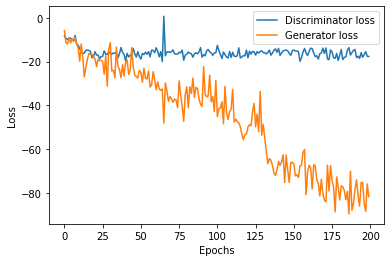

In [276]:
# Train WGAN-GP
gan = GAN()
gan.compile()
gan.train(real_sequences, epochs = 200)
gan.plot_history()

In [277]:
gan.show_sequences_history()

History of generated sequences... 

Epoch 0: 	 ['WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW']
Epoch 1: 	 ['WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW']
Epoch 2: 	 ['WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW']
Epoch 3: 	 ['WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW']
Epoch 4: 	 ['WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW']
Epoch 5: 	 ['WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW']
Epoch 6: 	 ['WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW']
Epoch 7: 	 ['WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW']
Epoch 8: 	 ['WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW']
Epoch 9: 	 ['WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW']
Epoch 10: 	 ['WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW']
Epoch 11: 	 ['WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW']
Epoch 12: 	 ['WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW']
Epoch 13: 	 ['WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW']
Epoch 14: 	 ['WWWWWWWWWWWWWWWWWWWWWW

**Hyperparameters: History**

With gradient penalty, 2000 samples, 200 epochs, sequence length = 40-50 aa, pretrained discriminator 5 times

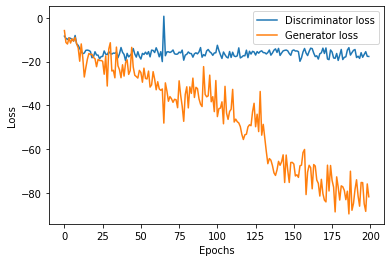

With gradient penalty, 1000 samples, 100 epochs, sequence length = 40-50 aa

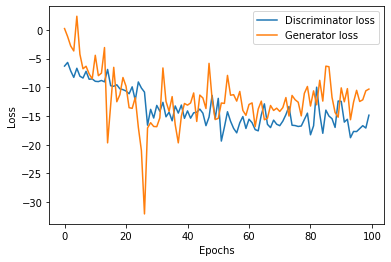

With gradient penalty, 1000 samples, 100 epochs,  sequence length = 3-50 aa

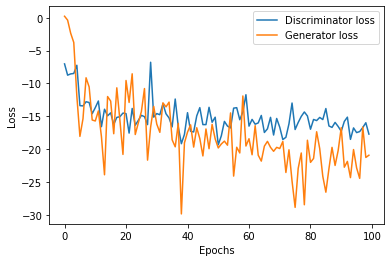

Without gradient penalty, 500 samples, 20 epochs

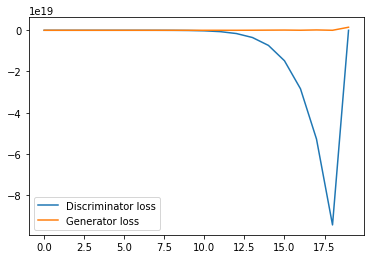